In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))

from matplotlib import pyplot as plt
import numpy as np
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import msh_parser
from dg_maxwell import advection_2d
from dg_maxwell import global_variables as gvar
from dg_maxwell import utils
from dg_maxwell import advection_2d_arbit_mesh as a2d_arbit_mesh
from dg_maxwell import wave_equation_2d
from dg_maxwell import lagrange

af.set_backend(params.backend)
af.set_device(params.device)

plt.rcParams['figure.figsize']     = 12, 7.5
plt.rcParams['lines.linewidth']    = 1.5
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.weight']        = 'bold'
plt.rcParams['font.size']          = 20  
plt.rcParams['font.sans-serif']    = 'serif'
plt.rcParams['text.usetex']        = True
plt.rcParams['axes.linewidth']     = 1.5
plt.rcParams['axes.titlesize']     = 'medium'
plt.rcParams['axes.labelsize']     = 'medium'

plt.rcParams['xtick.major.size']   = 8
plt.rcParams['xtick.minor.size']   = 4
plt.rcParams['xtick.major.pad']    = 8
plt.rcParams['xtick.minor.pad']    = 8
plt.rcParams['xtick.color']        = 'k'
plt.rcParams['xtick.labelsize']    = 'medium'
plt.rcParams['xtick.direction']    = 'in'    

plt.rcParams['ytick.major.size']   = 8
plt.rcParams['ytick.minor.size']   = 4
plt.rcParams['ytick.major.pad']    = 8
plt.rcParams['ytick.minor.pad']    = 8
plt.rcParams['ytick.color']        = 'k'
plt.rcParams['ytick.labelsize']    = 'medium'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['text.usetex']        = True
plt.rcParams['text.latex.unicode'] = True

[[ 0  9]
 [10 19]
 [20 29]
 [30 39]
 [40 49]
 [50 59]
 [60 69]
 [70 79]
 [80 89]
 [90 99]]
[[ 0 90]
 [ 1 91]
 [ 2 92]
 [ 3 93]
 [ 4 94]
 [ 5 95]
 [ 6 96]
 [ 7 97]
 [ 8 98]
 [ 9 99]]
gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


In [2]:
params.mesh_file = '../read_and_plot_mesh/mesh/square_10_10.msh'
advec_var = gvar.advection_variables(params.N_LGL, params.N_quad,
                                     params.x_nodes, params.N_Elements,
                                     params.c, params.total_time, params.wave,
                                     params.c_x, params.c_y, params.courant,
                                     params.mesh_file, params.total_time_2d)
new_elements = msh_parser.rearrange_element_edges(advec_var.elements, advec_var)
advec_var.reassign_2d_elements(new_elements)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


gmshTranslator: Initializing...
gmshTranslator: Mesh has 441 nodes.
gmshTranslator: Mesh has 144 elements.
gmshTranslator: Processed 589 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements
advection_variables __init__ completed


gmshTranslator: Ending


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


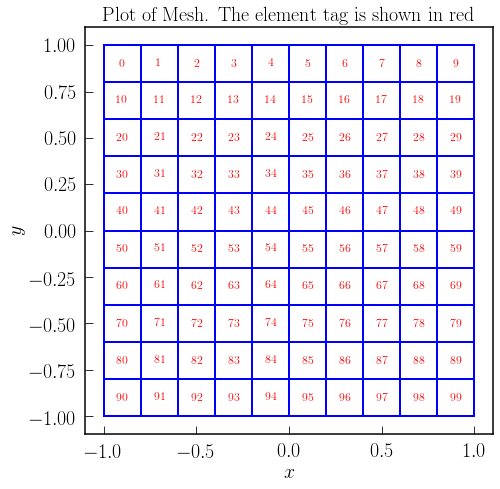

In [3]:
axes_handler = plt.axes()


msh_parser.plot_mesh_grid(advec_var.nodes, advec_var.elements,
                          advec_var.xi_LGL, advec_var.eta_LGL,
                          axes_handler, plot_LGL_grid = False,
                          print_element_tag = True)

plt.title(r'Plot of Mesh. The element tag is shown in red')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axes().set_aspect('equal')

plt.savefig('square.png')
plt.show()

In [17]:
sigma = 0.4
E_z_init = np.e**(- (advec_var.x_e_ij**2 + advec_var.y_e_ij**2) / sigma**2)
B_x_init = np.e**(- (advec_var.y_e_ij**2) / sigma**2)
B_y_init = np.e**(- (advec_var.x_e_ij**2) / sigma**2)

u_init = af.join(dim = 2, first = E_z_init, second = B_x_init, third = B_y_init)

In [18]:
print(u_init.shape)

(64, 100, 3)


In [19]:
gauss_points    = advec_var.gauss_points
gauss_weights   = advec_var.gauss_weights
dLp_Lq          = advec_var.dLp_Lq
dLq_Lp          = advec_var.dLq_Lp
xi_LGL          = advec_var.xi_LGL
lagrange_coeffs = advec_var.lagrange_coeffs
Li_Lj_coeffs    = advec_var.Li_Lj_coeffs
u               = advec_var.u_e_ij
lobatto_weights = advec_var.lobatto_weights_quadrature
x_e_ij          = advec_var.x_e_ij
y_e_ij          = advec_var.y_e_ij

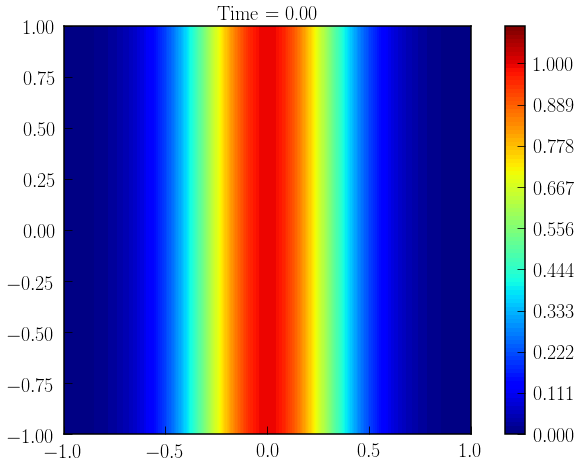

In [22]:
u = u_init[:, :, 2]
index = 0
color_levels = np.linspace(0, 1.1, 100)
u_plot = af.flip(af.moddims(u, params.N_LGL, params.N_LGL, 10, 10), 0)
x_plot = af.flip(af.moddims(x_e_ij, params.N_LGL, params.N_LGL, 10, 10), 0)
y_plot = af.flip(af.moddims(y_e_ij, params.N_LGL, params.N_LGL, 10, 10), 0)


x_contour = af.np_to_af_array(np.zeros([params.N_LGL * 10, params.N_LGL * 10]))
y_contour = af.np_to_af_array(np.zeros([params.N_LGL * 10, params.N_LGL * 10]))
u_contour = af.np_to_af_array(np.zeros([params.N_LGL * 10, params.N_LGL * 10]))
# fig = plt.figure()
#
for r in range(100):
    p = int(r / 10)
    q = r - p * 10
    x_contour[p * params.N_LGL:params.N_LGL * (p + 1),\
              q * params.N_LGL:params.N_LGL * (q + 1)] = x_plot[:, :, q, p]

    y_contour[p * params.N_LGL:params.N_LGL * (p + 1),\
              q * params.N_LGL:params.N_LGL * (q + 1)] = y_plot[:, :, q, p]

    u_contour[p * params.N_LGL:params.N_LGL * (p + 1),\
              q * params.N_LGL:params.N_LGL * (q + 1)] = u_plot[:, :, q, p]

x_contour = np.array(x_contour)
y_contour = np.array(y_contour)
u_contour = np.array(u_contour)
plt.contourf(x_contour, y_contour, u_contour, 200, levels = color_levels, cmap = 'jet')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Time = %.2f' %(index * 10 * advec_var.delta_t_2d))
# fig.savefig('results/2D_Wave_images/%04d' %(index) + '.png')
# plt.close('all')
plt.show()